# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import copy
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt

from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

# Define the models

### Cosmological correction

In [2]:
cor_chur2003 = 50.0/cosmo.H0.to_value('km s-1 Mpc-1')
cor_urb2014  = 70.0/cosmo.H0.to_value('km s-1 Mpc-1')
cor_chur2003, cor_urb2014

(0.7381163271331562, 1.0333628579864187)

### Churazov et al. (2003)

In [7]:
churazov2003 = minot.Cluster(name='Perseus', redshift=0.017284, M500=6.2e14*u.Msun, cosmology=cosmo, silent=True)
churazov2003.R_truncation = 5*churazov2003.R500
churazov2003.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chur2003, 'n_01':3.9e-2*u.cm**-3*cor_chur2003**-0.5,
                                  'beta2':0.58, 'r_c2':280*u.kpc*cor_chur2003, 'n_02':4.05e-3*u.cm**-3*cor_chur2003**-0.5}
radius = np.logspace(0,5,1000)*u.kpc
T_e = 7.0*(1+(radius.to_value('kpc')/(100.0*0.73))**3)/(2.3+(radius.to_value('kpc')/(100.0*0.73))**3)*u.keV
radius, n_e = churazov2003.get_density_gas_profile(radius)
P_e = n_e*T_e
churazov2003.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

### Churazov et al. (2003) + Urban et al. (2014)

In [8]:
#---------- Cluster definition
cluster = minot.Cluster(name='Perseus', redshift=0.017284, M500=6.2e14*u.Msun, cosmology=cosmo, silent=True)

#---------- Merge Churazov and Urban density profiles
theta_ref = 10*u.arcmin
# Total Churazov 2003 density
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chur2003, 'n_01':3.9e-2*u.cm**-3*cor_chur2003**-0.5,
                             'beta2':0.58, 'r_c2':280*u.kpc*cor_chur2003, 'n_02':4.05e-3*u.cm**-3*cor_chur2003**-0.5}
bid, nref1 = cluster.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(cluster.redshift))
# Outskirt Churazov 2003 density
cluster.density_gas_model = {'name':'beta', 'beta':0.58, 'r_c':280*u.kpc*cor_chur2003, 'n_0':4.05e-3*u.cm**-3*cor_chur2003**-0.5}
bid, nref2 = cluster.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(cluster.redshift))
# Urban 2014 normalized density
cluster.density_gas_model = {'name':'beta', 'beta':0.71, 'r_c':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(cluster.redshift), 'n_0':1*u.cm**-3*cor_urb2014**-0.5}
bid, nref3 = cluster.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(cluster.redshift))
# Merge the two unsuring consistency
cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chur2003, 'n_01':3.9e-2*u.cm**-3*cor_chur2003**-0.5,
                             'beta2':0.71, 'r_c2':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(cluster.redshift), 'n_02':(nref2/nref3).to_value('')*1*u.cm**-3*cor_urb2014**-0.5}
bid, nref4 = cluster.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(cluster.redshift))

#---------- Set the pressure
ctmp = copy.deepcopy(cluster)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
pgasmod = ctmp.pressure_gas_model
del pgasmod['c500']
cluster.pressure_gas_model = pgasmod

cluster.R_truncation = 5*cluster.R500

# Model to model comparison

('Hybrid model Uth500: ', <Quantity [2.0825596e+63] erg>)
('Churazov model Uth500: ', <Quantity [3.51960993e+63] erg>)


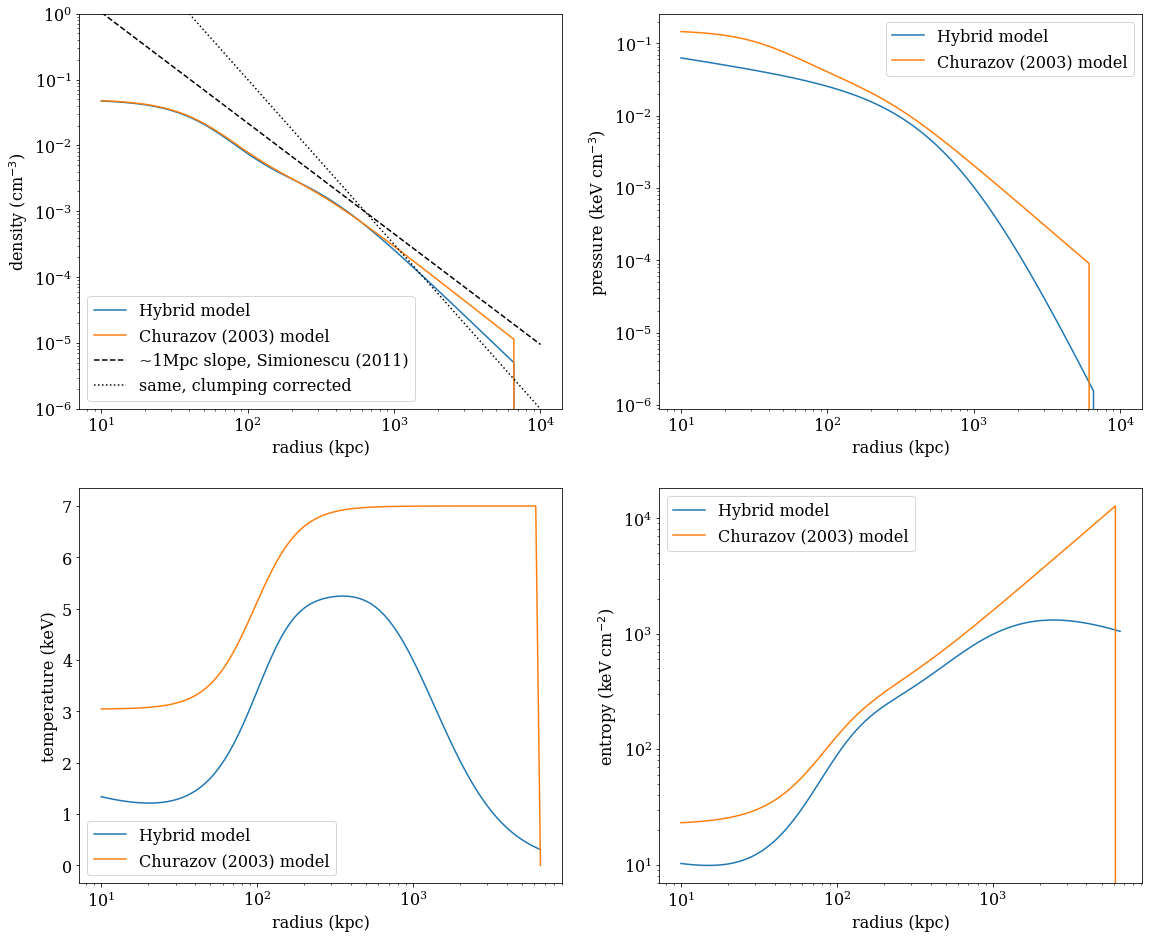

In [9]:
r = np.logspace(1,4,100)*u.kpc

fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
r,n = cluster.get_density_gas_profile(r)
plt.loglog(r,n, label='Hybrid model')
r,n = churazov2003.get_density_gas_profile(r)
plt.loglog(r,n, label='Churazov (2003) model')
plt.loglog(r, 50*r**-1.68, linestyle='--', color='k', label='~1Mpc slope, Simionescu (2011)')
plt.loglog(r, 10000*r**-2.50, linestyle=':', color='k', label='same, clumping corrected')
plt.xlabel('radius (kpc)')
plt.ylabel('density (cm$^{-3}$)')
plt.ylim(1e-6,1e0)
plt.legend()

ax = plt.subplot(222)
r,p = cluster.get_pressure_gas_profile(r)
plt.loglog(r,p, label='Hybrid model')
r,p = churazov2003.get_pressure_gas_profile(r)
plt.loglog(r,p, label='Churazov (2003) model')
plt.xlabel('radius (kpc)')
plt.ylabel('pressure (keV cm$^{-3}$)')
plt.legend()

ax = plt.subplot(223)
r,t = cluster.get_temperature_gas_profile(r)
plt.plot(r,t, label='Hybrid model')
r,t = churazov2003.get_temperature_gas_profile(r)
plt.plot(r,t, label='Churazov (2003) model')
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('temperature (keV)')
plt.legend()

ax = plt.subplot(224)
r,k = cluster.get_entropy_gas_profile(r)
plt.loglog(r,k, label='Hybrid model')
r,k = churazov2003.get_entropy_gas_profile(r)
plt.loglog(r,k, label='Churazov (2003) model')
plt.xlabel('radius (kpc)')
plt.ylabel('entropy (keV cm$^{-2}$)')
plt.legend()

print('Hybrid model Uth500: ', cluster.get_thermal_energy_profile(radius=cluster.R500)[1])
print('Churazov model Uth500: ', churazov2003.get_thermal_energy_profile(radius=churazov2003.R500)[1])

# Comparison to Planck